# Continuous Futures

**Python implementation of a Continuous Futures time-series for German Government Bond Futures**

Link to related article series: 

## Basic Imports

In [1]:
import numpy as np 
import pandas as pd
import eikon as ek
import configparser
import warnings
warnings.filterwarnings('ignore')

## Visualization Imports

In [2]:
from pylab import plt
plt.style.use('ggplot')
%matplotlib inline
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## Setup Eikon Connection

In [3]:
config = configparser.ConfigParser() 
config.read('logins.cfg')

['logins.cfg']

In [4]:
ek.set_app_id(config['eikon']['app_id'])

## Data Retrieval and Time-Series Generation

Below we define functions for for firstly catching **Spliced Contratcs** Futures time-series from **Eikon** and then generating **Continuous Futures** based on the **Perpetual** (for 10 and 40 roll over days) and the **Panama Method**. **Futures Expiries** are read from an Excel File. We write everything in a dict called **data_dict**.

In [5]:
def get_fut_front_back(start_date, end_date, front_perpr = ['FGBLc1', 'FGBMc1', 'FGBSc1'], 
                back_perpr = ['FGBLc2', 'FGBMc2', 'FGBSc2'],
                fields = ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOLUME']):
    '''
    Fetch daily Futures data for front and back contract and return as dict of dfs.
    Pass in start and end date as 'yyyy-mm-dd'.
    Front and back contracts are passed as list objects with Bund, Bobl, Schatz
    as pre-selection.
    '''
    data_dict = {}
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    fields = fields
    for i in range(len(front_perpr)):
                data_dict[front_perpr[i][0:-2]] = ek.get_timeseries([
                                                    front_perpr[i], back_perpr[i]
                                                    ],
                                                    fields=fields,
                                                    start_date=str(start_date),
                                                    end_date=str(end_date),
                                                    interval='daily'
                                                    )       
    return data_dict

In [6]:
data_dict = get_fut_front_back('2017-1-1', '2017-11-17')

In [7]:
def get_perp_fut(market_data, expiry_dates, rollover_days=5, 
                 data_cols=['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOLUME']):
    '''
    Converts a df of pairs of Futures contracts ('Front' & 'Back' ) into a continuous
    time series returned as df.
    Pass in market data as df.
    expiry_dates takes an excel file (i.e. "Futures_Exp.xlsx")
    with column A beeing the Futures name and column B being the expiry date.
    No column headers.
    We take European dates (dd-mm-yyyy).
    
    '''
    #Prepare Input Data
    market_data.columns.set_levels(['Front', 'Back'], 0, inplace = True)
    expiry_dates = pd.read_excel(expiry_dates, header=None, index_col=0, squeeze=1)
    expiry_dates = pd.to_datetime(expiry_dates.values, dayfirst = True)
    columns = pd.MultiIndex.from_tuples(tuple(zip(
        ['Front'] * len(data_cols) + ['Back'] * len(data_cols), data_cols * 2)
                                             ))
    #Initialize Weight Matrix
    roll_weights = pd.DataFrame(np.zeros((len(market_data.index), 2 * len(data_cols))),
                        index = market_data.index, columns=columns)
    #Weights depending on roll over days
    decay_weights = np.repeat(np.linspace(0, 1, rollover_days + 1),
                        int(len(data_cols))).reshape(rollover_days + 1,
                            int(len(data_cols)))
    #Update Weight Matrix
    for i in range(len(expiry_dates)):
        roll_weights.loc[expiry_dates[i]:, 'Front'] = 1
        roll_weights_target = roll_weights.iloc[
                            roll_weights.index.get_loc(expiry_dates[i]) - rollover_days :
                            roll_weights.index.get_loc(expiry_dates[i]) + 1
                            ].index 
        roll_weights.loc[roll_weights_target, 'Back'] = decay_weights
        roll_weights.loc[roll_weights_target, 'Front'] = 1 - decay_weights
    
    roll_weights_target = roll_weights.iloc[
                        0 : roll_weights.index.get_loc(expiry_dates[0]) - rollover_days
                        ].index
    roll_weights.loc[roll_weights_target, 'Front'] = 1
    #Update time-series data
    weighted_fut = roll_weights * market_data
    perp_fut = weighted_fut['Front'] + weighted_fut['Back'].fillna(0)
    return perp_fut

In [8]:
def get_pan_fut(market_data, expiry_dates, 
                data_cols=['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOLUME']):
    '''
    Converts a df of pairs of Futures contracts ('Front' & 'Back' )
    into a continuous time series returned as df.
    Pass in market data as df.
    expiry_dates takes an excel file (i.e. "Futures_Exp.xlsx")
    with column A beeing the Futures name and column B being the expiry date.
    No column headers. We take European dates (dd-mm-yyyy).
    
    '''
    #Prepare Input Data
    market_data.columns.set_levels(['Front', 'Back'], 0, inplace = True)
    expiry_dates = pd.read_excel(expiry_dates, header=None, index_col=0, squeeze=1)
    expiry_dates = pd.to_datetime(expiry_dates.values, dayfirst = True)
    #Initialize DFs for Futures data & roll adjustment for expired contracts
    pan_fut = pd.DataFrame(np.zeros((len(market_data.index), len(data_cols))), 
                        index = market_data.index, columns=data_cols)
    roll_adjustment_total = np.zeros([len(data_cols), 1])
    #Set data for last (unadjusted) Futures
    pan_fut.iloc[pan_fut.index.get_loc(expiry_dates[-1]) + 1:] = market_data['Front'].iloc[
        market_data['Front'].index.get_loc(expiry_dates[-1]) + 1:]
    #Find roll gap (we average over the last 5 trading days) backwards through contracts
    #and cumsum for total adjustment (due to better data quality we take all gaps from
    #close prices)
    for i in reversed(range(len(expiry_dates))):
        pan_fut.loc[expiry_dates[i]] = roll_adjustment_total.reshape(
            1, len(data_cols)) + market_data['Back'].loc[expiry_dates[i]].values
        roll_adjustment = market_data['Back']['CLOSE'].iloc[
            market_data['Front'].index.get_loc(expiry_dates[i]) - 4:
            market_data['Front'].index.get_loc(expiry_dates[i])
        ] - market_data['Front']['CLOSE'].iloc[
            market_data['Back'].index.get_loc(expiry_dates[i]) - 4:
            market_data['Back'].index.get_loc(expiry_dates[i])
        ]
        roll_adjustment = np.repeat(roll_adjustment.values.mean(), len(data_cols) - 1)
        roll_adjustment = np.append(roll_adjustment, 0)
        roll_adjustment = roll_adjustment.reshape(len(data_cols), 1)
        roll_adjustment_total += roll_adjustment
        #Most recent expired contract back to oldest + 1 contract
        if i > 0:
            roll_target = market_data['Front'].iloc[
                market_data['Front'].index.get_loc(expiry_dates[i - 1]) + 1:
                market_data['Front'].index.get_loc(expiry_dates[i])].index
            roll_adjustment_target = np.tile(roll_adjustment_total, len(roll_target)).T
            pan_fut.loc[roll_target] = roll_adjustment_target + market_data['Front'].loc[
                roll_target]
        #Oldest contract in data set
        else:
            roll_target = market_data['Front'].iloc[
                0:market_data['Front'].index.get_loc(expiry_dates[i])].index
            roll_adjustment_target = np.tile(roll_adjustment_total, len(roll_target)).T
            pan_fut.loc[roll_target] = roll_adjustment_target + market_data['Front'].loc[
                roll_target]
    return pan_fut


In [9]:
for key in data_dict.copy().keys(): 
    data_dict['%s_perp_10' % key] = get_perp_fut(
        data_dict[key], 'Gov_Futures_Exp.xlsx', rollover_days=10)
    data_dict['%s_perp_40' % key] = get_perp_fut(
        data_dict[key], 'Gov_Futures_Exp.xlsx', rollover_days=40)
    data_dict['%s_pan' % key] = get_pan_fut(data_dict[key], 'Gov_Futures_Exp.xlsx')

## Visualization with Matplotlib

We compare all generated time-series visually with **Matplotlib**.

In [10]:
plt.rcParams['figure.figsize'] = (12, 14)

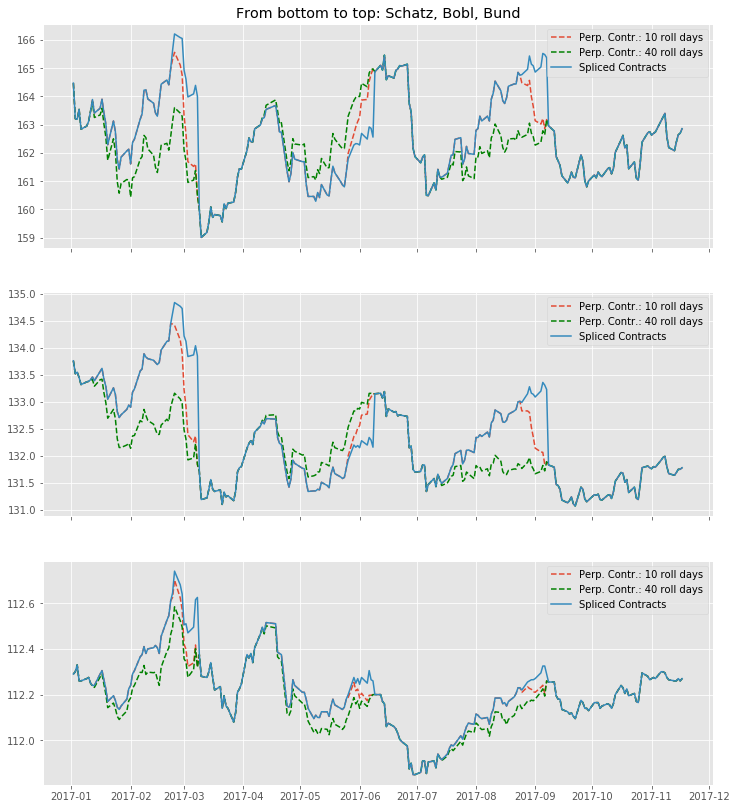

In [11]:
f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(data_dict['FGBL_perp_10']['CLOSE'].index,
         data_dict['FGBL_perp_10']['CLOSE'], label='Perp. Contr.: 10 roll days',
              linestyle='--')
axarr[0].plot(data_dict['FGBL_perp_40']['CLOSE'].index,
         data_dict['FGBL_perp_40']['CLOSE'], label='Perp. Contr.: 40 roll days',
              color='g', linestyle='--')
axarr[0].plot(data_dict['FGBL']['Front']['CLOSE'].index,
         data_dict['FGBL']['Front']['CLOSE'], label='Spliced Contracts')
axarr[0].legend(loc='upper right')
axarr[0].set_title('From bottom to top: Schatz, Bobl, Bund')
axarr[1].plot(data_dict['FGBM_perp_10']['CLOSE'].index,
         data_dict['FGBM_perp_10']['CLOSE'], label='Perp. Contr.: 10 roll days',
              linestyle='--')
axarr[1].plot(data_dict['FGBM_perp_40']['CLOSE'].index,
         data_dict['FGBM_perp_40']['CLOSE'], label='Perp. Contr.: 40 roll days',
              color='g', linestyle='--')
axarr[1].plot(data_dict['FGBM']['Front']['CLOSE'].index,
         data_dict['FGBM']['Front']['CLOSE'], label='Spliced Contracts')
axarr[1].legend(loc='upper right')
axarr[2].plot(data_dict['FGBS_perp_10']['CLOSE'].index,
         data_dict['FGBS_perp_10']['CLOSE'], label='Perp. Contr.: 10 roll days',
              linestyle='--')
axarr[2].plot(data_dict['FGBS_perp_40']['CLOSE'].index,
         data_dict['FGBS_perp_40']['CLOSE'], label='Perp. Contr.: 40 roll days',
              color='g', linestyle='--')
axarr[2].plot(data_dict['FGBS']['Front']['CLOSE'].index,
         data_dict['FGBS']['Front']['CLOSE'], label='Spliced Contracts')
axarr[2].legend(loc='upper right')
plt.savefig('perpetual_contract.png', transparent = False, bbox_inches='tight');


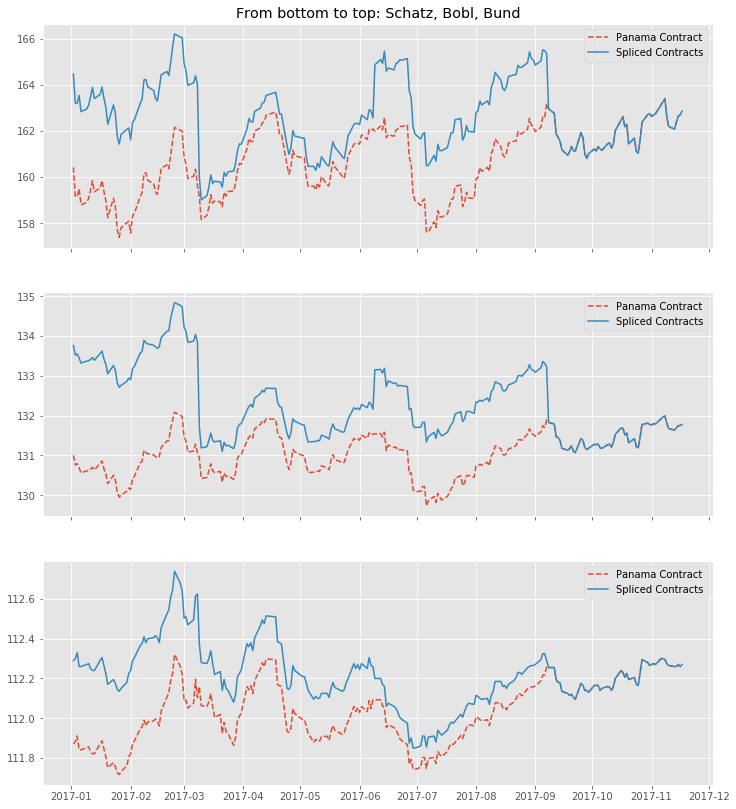

In [12]:
f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(data_dict['FGBL_pan']['CLOSE'].index,
         data_dict['FGBL_pan']['CLOSE'], label='Panama Contract', linestyle='--')
axarr[0].plot(data_dict['FGBL']['Front']['CLOSE'].index,
         data_dict['FGBL']['Front']['CLOSE'], label='Spliced Contracts')
axarr[0].legend(loc='upper right')
axarr[0].set_title('From bottom to top: Schatz, Bobl, Bund')
axarr[1].plot(data_dict['FGBM_pan']['CLOSE'].index,
         data_dict['FGBM_pan']['CLOSE'], label='Panama Contract', linestyle='--')
axarr[1].plot(data_dict['FGBM']['Front']['CLOSE'].index,
         data_dict['FGBM']['Front']['CLOSE'], label='Spliced Contracts')
axarr[1].legend(loc='upper right')
axarr[2].plot(data_dict['FGBS_pan']['CLOSE'].index,
         data_dict['FGBS_pan']['CLOSE'], label='Panama Contract', linestyle='--')
axarr[2].plot(data_dict['FGBS']['Front']['CLOSE'].index,
         data_dict['FGBS']['Front']['CLOSE'], label='Spliced Contracts')
axarr[2].legend(loc='upper right')
plt.savefig('panama_contract.png', transparent = False, bbox_inches='tight');

## Analysis with Plotly and Cufflinks

We further dig into the performance of our **Continuous Futures** by looking into signals generated from various technical indicators. As the **Panama Method** was most appealing to us, we spare charts from the **Perpetual Method** here. We do this in two sections: Firstly, we present **Ploty Charts** as a mean of comparison, afterwards we do some analysis on the generated signals by comparing the methods **quantitatively**.

### Visualization

Setting up **Cufflinks QuantFigs**.

In [13]:
plot_list = ['FGBL', 'FGBL_pan', 'FGBM', 'FGBM_pan', 'FGBS', 'FGBS_pan']
plot_titles = ['Bund Spliced', 'Bund Panama', 'Bobl Spliced',
               'Bobl Panama', 'Schatz Spliced', 'Schatz Panama']

In [14]:
qf_list = []

In [15]:
for i, j in enumerate(plot_list):
    if i % 2 == 0:
        qf_list.append(cf.QuantFig(
            data_dict[j]['Front']['2017-1-1':'2017-11-17'],
            title=plot_titles[i],
            legend='top',
            name=plot_titles[i],
            datalegend=False,
            rangeselector=dict(steps=['Reset','6M','3M','1M'],
                                    bgcolor=('rgb(150, 200, 250)',.1),
                                    fontsize=12, fontfamily='monospace', x=0, y=1)
        ))
    else:
        qf_list.append(cf.QuantFig(
            data_dict[j]['2017-1-1':'2017-11-17'],
            title=plot_titles[i],
            legend='top',
            name=plot_titles[i],
            datalegend=False,
            rangeselector=dict(steps=['Reset','6M','3M','1M'],
                                    bgcolor=('rgb(150, 200, 250)',.1),
                                    fontsize=12, fontfamily='monospace', x=0, y=1)
        ))

Enrich **QuantFigs** with technical studies and highlight **Futures Expiries**. Transform objects to a **Plotly Chart Object** for further editing.

In [16]:
def cf_objects(qf_list, expiry_dates):
    qf_list = qf_list
    plt_list = []
    expiry_dates = pd.read_excel(expiry_dates, header=None, index_col=0, squeeze=1)
    expiry_dates = pd.to_datetime(expiry_dates.values, dayfirst = True)
    for i, qf in enumerate(qf_list):
        for d in expiry_dates:
            qf.add_shapes(shapes=dict(kind='line', x0=d, x1=d, yref='paper', y0=0, y1=1,
                              color='grey', dash='dot'))
        qf.add_volume(colorchange=True)
        qf.add_macd(fast_period=12, slow_period=26, signal_period=9, name='MACD')
        qf.studies['macd']['display'].update(legendgroup=True)
        qf.data.update(showlegend=False)
        qf.add_ema(colors='brown', name='EMA')
        qf.add_bollinger_bands(periods=20, boll_std=2, colors=['magenta', 'grey'], name='BOLL')
        qf.add_rsi(periods=20, rsi_upper=70, rsi_lower=30, name='RSI')
        qf.data.update(showlegend=False)
        plt_list.append(qf_list[i].iplot(asFigure=True))
        dict(plt_list[i])['data'][1]['showlegend'] = False
        dict(plt_list[i])['data'][3]['name'] = 'EMA'
        dict(plt_list[i])['data'][7]['showlegend'] = False
        dict(plt_list[i])['data'][8]['showlegend'] = False
        dict(plt_list[i])['data'][9]['showlegend'] = False
        dict(plt_list[i])['data'][0]['showlegend'] = False
    return plt_list

In [17]:
plt_list = cf_objects(qf_list, 'Gov_Futures_Exp.xlsx')

Setup appearance and proportions for **Plotly**.

In [18]:
def plt_layout(plt_list):
    plt_list = plt_list
    global_layout = {}
    for qf in range(len(plt_list)):

        # Set Chart proportions & subplot titles
        global_layout['layout%s' % (qf,)] = {'layout': {
            'width':800,
            'height':800,
            'margin': {
                'l':55,
                'r':30,
                'b':30,
                't':30},
            'yaxis2': {
                'domain': (0.39, 1),
           'gridcolor': '#E1E5ED',
           'showgrid': True,
           'tickfont': {'color': '#4D5663'},
           'title': 'Price',
           'titlefont': {'color': '#4D5663'},
           'zerolinecolor': '#E1E5ED'
            },
            'yaxis3': {
                'domain': (0.26, 0.36),
           'gridcolor': '#E1E5ED',
           'showgrid': True,
           'tickfont': {'color': '#4D5663'},
           'title': 'VOL',
           'titlefont': {'color': '#4D5663'},
           'zerolinecolor': '#E1E5ED'
            },
          'yaxis4': {
              'domain': (0.13, 0.23),
           'gridcolor': '#E1E5ED',
           'showgrid': True,
           'tickfont': {'color': '#4D5663'},
           'title': 'MACD',
           'titlefont': {'color': '#4D5663'},
           'zerolinecolor': '#E1E5ED'
          },
          'yaxis5': {
              'domain': (0.0, 0.1),
           'gridcolor': '#E1E5ED',
           'showgrid': True,
           'tickfont': {'color': '#4D5663'},
           'title': 'RSI',
           'titlefont': {'color': '#4D5663'},
           'zerolinecolor': '#E1E5ED'
          }}}
        plt_list[qf].update(global_layout['layout%s' % (qf,)])
    return plt_list, global_layout
    

In [19]:
plt_list, global_layout = plt_layout(plt_list)

Make **annotations** for trading signals from **MACD** and **RSI** directly in **Candlestick Chart**.

In [20]:
def an_macd_rsi(plt_list, global_layout, disp_ith_mark = 10):
    plt_list = plt_list
    global_layout = global_layout
    disp_ith_mark = disp_ith_mark
    signals = {}
    for qf in range(len(plt_list)):
        # Prepare Annotations
        ## MACD
        macd = pd.DataFrame(data=[dict(plt_list[qf])['data'][2]['y'],
                                  dict(plt_list[qf])['data'][1]['y']]).T
        macd['Date'] = dict(plt_list[qf])['data'][1]['x']
        macd.set_index('Date', inplace = True)
        macd.columns = ['Signal', 'Basis']
        macd['Signal'].replace(0, np.nan, inplace = True)
        macd['Up'] = np.where(macd['Signal'] > macd['Basis'], 1, 0)
        macd['Cross'] = np.where(macd['Up'] - macd['Up'].shift() == 0, 0, 'MACD Signal')
        macd['Cross'].iloc[:2] = 0
        ## RSI
        rsi = pd.DataFrame(data=[dict(plt_list[qf])['data'][7]['y'],
                                 dict(plt_list[qf])['data'][8]['y'],
                                 dict(plt_list[qf])['data'][9]['y']]).T
        rsi['Date'] = dict(plt_list[qf])['data'][7]['x']
        rsi.set_index('Date', inplace = True)
        rsi.columns = ['Signal', 'Lower', 'Upper']
        rsi['Signal'].replace('', np.nan, inplace = True)
        rsi.dropna(inplace = True)
        rsi['Up'] = np.where(rsi['Signal'] > rsi['Upper'], 1, 0)
        rsi['Up_Cross'] = np.where(rsi['Up'] - rsi['Up'].shift() == 0, 0, 1)
        rsi['Down'] = np.where(rsi['Signal'] < rsi['Lower'], 1, 0)
        rsi['Down_Cross'] = np.where(rsi['Down'] - rsi['Down'].shift() == 0, 0, 1)
        rsi['Sum_Cross'] = np.where(rsi['Up_Cross'] == 1, 'RSI Signal',
                                    np.where(rsi['Down_Cross'] == 1, 'RSI Signal', 0))
        rsi['Sum_Cross'].iloc[:1] = 0
        ## Set Signals per Security and Study to dict
        signals["Sec%s" % (qf,)] = {}
        if qf % 2 != 0:
            signals["Sec%s" % (qf,)]['MACD'] = data_dict[plot_list[qf]].join(
                macd.loc[macd['Cross'] == 'MACD Signal']['Cross'],
                                        how = 'inner')['HIGH']
            signals["Sec%s" % (qf,)]['RSI'] = data_dict[plot_list[qf]].join(
                                        rsi.loc[rsi['Sum_Cross'] == 'RSI Signal']['Sum_Cross'],
                                        how = 'inner')['LOW']
        else:
            signals["Sec%s" % (qf,)]['MACD'] = data_dict[plot_list[qf]]['Front'].join(
                                        macd.loc[macd['Cross'] == 'MACD Signal']['Cross'],
                                        how = 'inner')['HIGH']
            signals["Sec%s" % (qf,)]['RSI'] = data_dict[plot_list[qf]]['Front'].join(
                                        rsi.loc[rsi['Sum_Cross'] == 'RSI Signal']['Sum_Cross'],
                                        how = 'inner')['LOW']
        # Update Annotations
        global_layout['layout%s' % (qf,)]['layout']['annotations'] = []
        for i in signals['Sec%s' % (qf,)].keys():
            for j, (key, value) in enumerate(signals['Sec%s' % (qf,)][i].iteritems()):
                if i == 'MACD':
                    if j % disp_ith_mark == 0: 
                        global_layout['layout%s' % (qf,)]['layout']['annotations'].append(dict(
                                    x=key,
                                    y=value,
                                    xref='x',
                                    yref='y',
                                    text=i,
                                    showarrow=True,
                                    arrowhead=2,
                                    ax=0,
                                    ay=-70
                                ))
                    else:
                        global_layout['layout%s' % (qf,)]['layout']['annotations'].append(dict(
                                    x=key,
                                    y=value,
                                    xref='x',
                                    yref='y',
                                    text='',
                                    showarrow=True,
                                    arrowhead=2,
                                    ax=0,
                                    ay=-10
                                ))
                else:
                    if j % disp_ith_mark == 0: 
                        global_layout['layout%s' % (qf,)]['layout']['annotations'].append(dict(
                                    x=key,
                                    y=value,
                                    xref='x',
                                    yref='y',
                                    text=i,
                                    showarrow=True,
                                    arrowhead=7,
                                    ax=0,
                                    ay=70
                                ))
                    else:
                        global_layout['layout%s' % (qf,)]['layout']['annotations'].append(dict(
                                    x=key,
                                    y=value,
                                    xref='x',
                                    yref='y',
                                    text='',
                                    showarrow=True,
                                    arrowhead=7,
                                    ax=0,
                                    ay=0
                                ))

        plt_list[qf].update(global_layout['layout%s' % (qf,)])
    return plt_list


In [21]:
plt_list = an_macd_rsi(plt_list, global_layout)

In [22]:
for qf in plt_list:
    iplot(qf, show_link = False)

In [23]:
#div 
#for qf in plt_list:
    #print(plot(qf, include_plotlyjs=False, output_type='div'))
 

### Quantifying the Trading Signals

In [24]:
print('Signal Count for Bund, Bobl, Schatz (separated by:\'--\'):\n\n', 7* ' ','MACD', 'RSI')
for i in range(6):
    no_macd_sig = 0
    no_rsi_sig = 0
    if i % 2 == 0: print(17*'-')
    for j in global_layout['layout%s' %i]['layout']['annotations']:
        if (j['arrowhead']) == 2:
            no_macd_sig += 1
        else:
            no_rsi_sig += 1
    if i % 2 == 0: print('Spliced ',no_macd_sig,' ',no_rsi_sig)
    else: print('Panama  ',no_macd_sig,' ',no_rsi_sig)

Signal Count for Bund, Bobl, Schatz (separated by:'--'):

         MACD RSI
-----------------
Spliced  14   34
Panama   14   26
-----------------
Spliced  12   29
Panama   14   23
-----------------
Spliced  17   10
Panama   15   10


In [25]:
signal_dates = {}
for i in range(6):
    signal_dates['layout%s' %i] = {}
    signal_dates['layout%s' %i]['MACD'] = []
    signal_dates['layout%s' %i]['RSI'] = []
    for j in global_layout['layout%s' %i]['layout']['annotations']:
        if (j['arrowhead']) == 2:
            signal_dates['layout%s' %i]['MACD'].append(j['x']) 
        else:
            signal_dates['layout%s' %i]['RSI'].append(j['x'])

In [26]:
print('Signal Dates NOT shared by Spliced and Panama Contract'
      'for Bund, Bobl, Schatz (separated by:\'--\'):\n\n',
      3*' ', 'Unique Dates')
for i in range(0,6,2):
    print(17*'-')
    print('MACD     ',len(
        [x for x in signal_dates['layout%s' %i]['MACD'] if x not in 
         signal_dates['layout%s' %(i+1)]['MACD']]) + len(
        [x for x in signal_dates['layout%s' %(i+1)]['MACD'] if x not in
         signal_dates['layout%s' %i]['MACD']]))
    print('RSI      ',len(
        [x for x in signal_dates['layout%s' %i]['RSI'] if x not in 
         signal_dates['layout%s' %(i+1)]['RSI']]) + len(
        [x for x in signal_dates['layout%s' %(i+1)]['RSI'] if x not in
         signal_dates['layout%s' %i]['RSI']]))
    

Signal Dates NOT shared by Spliced and Panama Contractfor Bund, Bobl, Schatz (separated by:'--'):

     Unique Dates
-----------------
MACD      14
RSI       16
-----------------
MACD      16
RSI       14
-----------------
MACD      16
RSI       8
